# Comparison with the methods not considering cell type mixtures

In [11]:
set.seed(20240709)

library(MCube)
library(SPARK)
library(HEARTSVG)
library(ggplot2)

max_cores <- 36

In [2]:
RAW_DATA_PATH <- "/import/home/share/zw/data/DLPFC"
DATA_PATH <- "/import/home/share/zw/pql/data/DLPFC"
RESULT_PATH <- "/import/home/share/zw/pql/results/DLPFC"

if (!dir.exists(file.path(RESULT_PATH))) {
    dir.create(file.path(RESULT_PATH), recursive = TRUE)
}

In [13]:
# Use Slice 151673 as an example
slice_idx <- 151673

# Load in ST data
counts <- as.data.frame(readr::read_csv(file.path(DATA_PATH, "counts.csv")))
rownames(counts) <- counts[, 1]
counts[, 1] <- NULL
counts <- as.matrix(counts)
spots_names <- grep("-slice0$", rownames(counts), value = TRUE) # Spots at the first slice
counts <- counts[spots_names, ]
dim(counts)
# head(counts)
coordinates <- as.data.frame(readr::read_csv(file.path(DATA_PATH, "3D_coordinates.csv")))
rownames(coordinates) <- coordinates[, 1]
coordinates[, c(1, 4)] <- NULL
coordinates <- coordinates[spots_names, ]
dim(coordinates)
# head(coordinates)

New names:
• `` -> `...1`
Rows: 14243 Columns: 4559
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr    (1): ...1
dbl (4558): A2M, AAK1, AASDHPPT, AASS, AATK, ABCA1, ABCA2, ABCA5, ABCA8, ABC...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 3611 4558

New names:
• `` -> `...1`
Rows: 14243 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): ...1
dbl (3): x, y, z

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 3611    2

## Methods not considering cell type mixtures

`SPARK` and `SPARK-X` (<https://github.com/xzhoulab/SPARK>)

In [12]:
spark_obj <- CreateSPARKObject(counts = t(counts), location = coordinates)
spark_obj@lib_size <- rowSums(counts)

spark_obj <- spark.vc(
    spark_obj,
    covariates = NULL, lib_size = spark_obj@lib_size,
    num_core = max_cores, verbose = FALSE
)
spark_obj <- spark.test(spark_obj, check_positive = TRUE, verbose = FALSE)

saveRDS(spark_obj, file = file.path(RESULT_PATH, "spark.rds"))
# spark_obj <- readRDS(file.path(RESULT_PATH, "spark.rds"))

## ===== SPARK INPUT INFORMATION ==== 
## number of total samples:  3611 
## number of total features:  2049 
## number of adjusted covariates:  0 
# fitting count-based spatial model under the null hypothesis ... 
## testing Gaussian kernel: 1...
## testing Periodic kernel: 1...
## testing Gaussian kernel: 2...
## testing Periodic kernel: 2...
## testing Gaussian kernel: 3...
## testing Periodic kernel: 3...
## testing Gaussian kernel: 4...
## testing Periodic kernel: 4...
## testing Gaussian kernel: 5...
## testing Periodic kernel: 5...


In [16]:
sparkx_results <- sparkx(t(counts), as.matrix(coordinates), numCores = max_cores, option = "mixture")
saveRDS(sparkx_results, file = file.path(RESULT_PATH, "sparkx.rds"))
# sparkx_results <- readRDS(file.path(RESULT_PATH, "sparkx.rds"))

## ===== SPARK-X INPUT INFORMATION ==== 
## number of total samples: 3611 
## number of total genes: 4216 
## Running with 36 cores 
## Testing With Projection Kernel
## Testing With Gaussian Kernel 1
## Testing With Gaussian Kernel 2
## Testing With Gaussian Kernel 3
## Testing With Gaussian Kernel 4
## Testing With Gaussian Kernel 5
## Testing With Cosine Kernel 1
## Testing With Cosine Kernel 2
## Testing With Cosine Kernel 3
## Testing With Cosine Kernel 4
## Testing With Cosine Kernel 5


`HEARTSVG` (<https://github.com/cz0316/HEARTSVG>)

In [14]:
heartsvg_data <- cbind(coordinates, counts)
colnames(heartsvg_data)[1:2] <- c("row", "col")

heartsvg_results <- heartsvg(heartsvg_data, scale = TRUE)

write.csv(heartsvg_results,file.path(RESULT_PATH, "heartsvg_results.csv"))
# heartsvg_results <- read.csv(file.path(RESULT_PATH, "heartsvg_results.csv"), row.names = 1)

## Comparison of the SVG identification results

In [61]:
# Load in SVG identification results
spark_obj <- readRDS(file.path(RESULT_PATH, "spark.rds"))
sparkx_results <- readRDS(file.path(RESULT_PATH, "sparkx.rds"))
heartsvg_results <- read.csv(file.path(RESULT_PATH, "heartsvg_results.csv"), row.names = 1)
rownames(heartsvg_results) <- heartsvg_results$gene

In [62]:
demo_celltypes <- c("Oligos_3", "Ex_8_L5_6", "Ex_10_L2_4")
markers <- c("MAG", "KRT17", "HS6ST3")

In [63]:
others_pvalues_long <- rbind(
    data.frame(
        method = "SPARK",
        mcubeQQPlotDF(spark_obj@res_mtest, "combined_pvalue")
    ),
    data.frame(
        method = "SPARK-X",
        mcubeQQPlotDF(sparkx_results$res_mtest, "combinedPval")
    ),
    data.frame(
        method = "HEARTSVG",
        mcubeQQPlotDF(heartsvg_results, "p_adj")
    )
)
others_pvalues_long$case <- "Real case"
others_pvalues_long$case <- factor(others_pvalues_long$case, levels = c("Real case", "Negative control"))
# dim(others_pvalues_long)
# head(others_pvalues_long)

others_marker_pvalues <- others_pvalues_long[others_pvalues_long$gene %in% markers, ]
others_marker_pvalues

method   gene   pvalue        pvalue_theoretical minus_log10p
350  SPARK    HS6ST3  5.550000e-17 0.17057101         5           
400  SPARK    KRT17   5.550000e-17 0.19497316         5           
996  SPARK    MAG     2.220446e-16 0.48584675         5           
2105 SPARK-X  MAG    3.821175e-189 0.01316414         5           
2642 SPARK-X  HS6ST3  5.262656e-74 0.14053605         5           
3218 SPARK-X  KRT17   9.791988e-33 0.27715844         5           
7017 HEARTSVG MAG     0.000000e+00 0.17824953         5           
7148 HEARTSVG HS6ST3  0.000000e+00 0.20932163         5           
7169 HEARTSVG KRT17   0.000000e+00 0.21430266         5           
     minus_log10p_theoretical case     
350  0.7680948                Real case
400  0.7100252                Real case
996  0.3135007                Real case
2105 1.8806076                Real case
2642 0.8522122                Real case
3218 0.5572719                Real case
7017 0.7489716                Real case
7148 0.6791859                Real case
7169 0.6689724                Real case

The cell type marker genes are identified as SVGs by the methods not considering cell type mixtures.

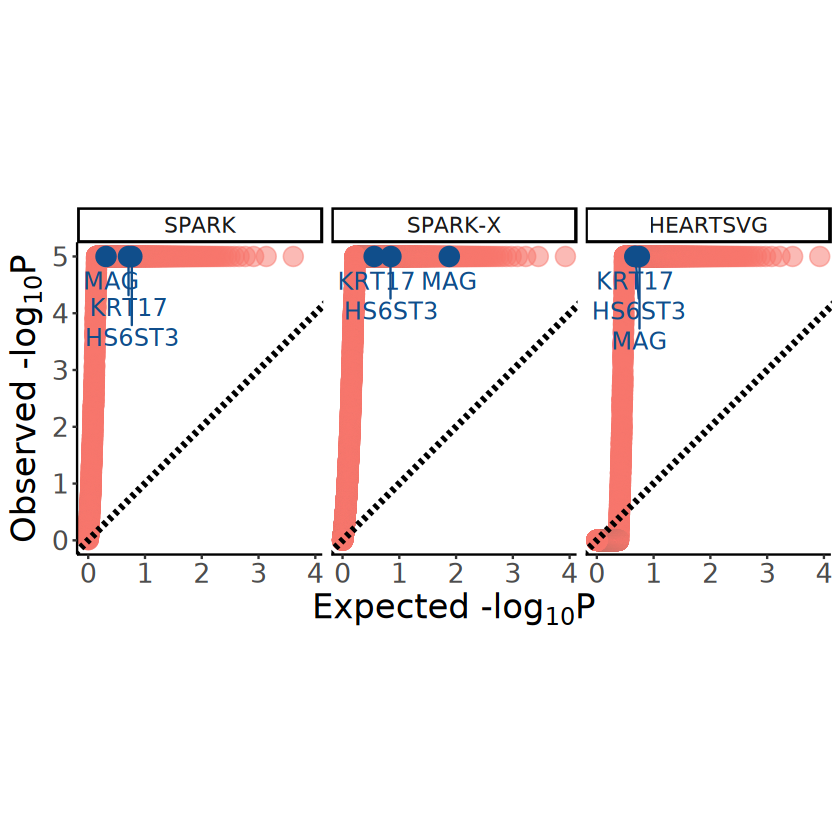

In [70]:
expected_minus_log10p_lab <- expression(paste("Expected -log"[10], plain(P)))
observed_minus_log10p_lab <- expression(paste("Observed -log"[10], plain(P)))

x_max <- max(others_pvalues_long$minus_log10p_theoretical)

p <- ggplot(
    data = others_pvalues_long,
    aes(x = minus_log10p_theoretical, y = minus_log10p)
) +
    geom_point(aes(color = case), alpha = 0.5, size = 5) +
    geom_abline(
        intercept = 0, slope = 1, linewidth = 1.5,
        linetype = "dashed", color = "black"
    ) +
    geom_point(data = others_marker_pvalues, color = "dodgerblue4", size = 5, alpha = 1) +
    ggrepel::geom_text_repel(
        data = others_marker_pvalues, aes(label = gene),
        color = "dodgerblue4", size = 5, fontface = "bold.italic",
        angle=0, direction = 'y', vjust=0, point.size = 5
    ) +
    xlim(0, x_max) +
    coord_fixed(ratio = 1) +
    facet_wrap(~ factor(method, c("SPARK", "SPARK-X", "HEARTSVG")), nrow = 1) +
    labs(
        title = NULL,
        x = expected_minus_log10p_lab, y = observed_minus_log10p_lab
    ) +
    theme_classic() +
    theme(
        text = element_text(size = 16),
        plot.title = element_text(size = 20),
        axis.title = element_text(size = 20),
        axis.text.x = element_text(size = 16),
        axis.text.y = element_text(size = 16),
        legend.position = "none"
    )
ggsave(
    filename = file.path(RESULT_PATH, "others_marker.pdf"),
    plot = p, width = 8, height = 4
)
p

In [66]:
# Load in MCube results
mcube_object <- readRDS(file.path(RESULT_PATH, paste0("mcube_", slice_idx, ".rds")))
mcube_pvalues <- mcube_object@pvalues
mcube_pvalues_null <- readRDS(file.path(RESULT_PATH, paste0("pvalues_", slice_idx, "_null.rds")))

In [68]:
mcube_pvalues_long <- rbind(
    do.call(
        rbind,
        lapply(
            names(mcube_pvalues),
            FUN = function(x) {
                data.frame(
                    celltype = x,
                    mcubeQQPlotDF(mcube_pvalues[[x]]),
                    case = "Real case"
                )
            }
        )
    ),
    do.call(
        rbind,
        lapply(
            names(mcube_pvalues_null),
            FUN = function(x) {
                data.frame(
                    celltype = x,
                    mcubeQQPlotDF(mcube_pvalues_null[[x]]),
                    case = "Negative control"
                )
            }
        )
    )
)
mcube_pvalues_long$case <- factor(mcube_pvalues_long$case, levels = c("Real case", "Negative control"))
mcube_pvalues_long <- mcube_pvalues_long[mcube_pvalues_long$celltype %in% demo_celltypes, ]
# head(mcube_pvalues_long)

mcube_marker_pvalues <- mcube_pvalues_long[
    mcube_pvalues_long$gene %in% markers & mcube_pvalues_long$case == "Real case",
]
mcube_marker_pvalues

celltype   gene   pvalue     pvalue_theoretical minus_log10p
1157 Ex_10_L2_4 HS6ST3 0.60447192 0.7992308          0.2186239   
4036 Ex_8_L5_6  KRT17  0.07661555 0.1873041          1.1156831   
5748 Oligos_3   MAG    0.45923093 0.7320896          0.3379689   
     minus_log10p_theoretical case     
1157 0.0973278                Real case
4036 0.7274528                Real case
5748 0.1354358                Real case

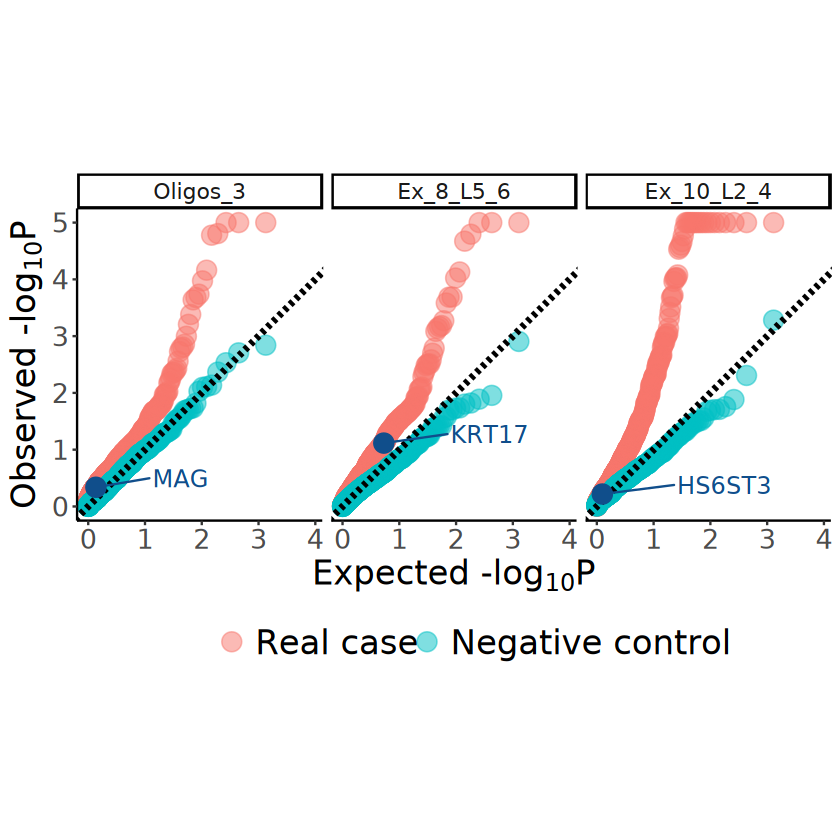

In [73]:
# x_max <- max(mcube_pvalues_long$minus_log10p_theoretical)

p <- ggplot(
    data = mcube_pvalues_long, aes(x = minus_log10p_theoretical, y = minus_log10p)
) +
    geom_point(alpha = 0.5, aes(color = case), size = 5) +
    scale_color_discrete(name = "Case", labels = c("Real case", "Negative control")) +
    geom_abline(
        intercept = 0, slope = 1, linewidth = 1.5,
        linetype = "dashed", color = "black"
    ) +
    geom_point(data = mcube_marker_pvalues, color = "dodgerblue4", size = 5, alpha = 1) +
    ggrepel::geom_text_repel(
        data = mcube_marker_pvalues, aes(label = gene),
        color = "dodgerblue4", size = 5, fontface = "bold.italic",
        angle = 0, hjust = -0.5, vjust = 0, nudge_x = 0.5, point.size = 5
    ) +
    xlim(0, x_max) +
    coord_fixed(ratio = 1) +
    facet_wrap(~ factor(celltype, c("Oligos_3", "Ex_8_L5_6", "Ex_10_L2_4")), nrow = 1) +
    labs(
        title = NULL,
        x = expected_minus_log10p_lab, y = observed_minus_log10p_lab
    ) +
    theme_classic() +
    theme(
        text = element_text(size = 16),
        plot.title = element_text(size = 20),
        axis.title = element_text(size = 20),
        axis.text.x = element_text(size = 16),
        axis.text.y = element_text(size = 16),
        legend.position = "bottom",
        legend.title = element_blank(),
        legend.text = element_text(size = 20)
    )
ggsave(
    file.path(RESULT_PATH, "MCube_marker.pdf"),
    plot = p, width = 8, height = 4
)
p

In [ ]:
# Load in H&E image
he_image <- tiff::readTIFF(
    file.path(
        RAW_DATA_PATH, "spatialLIBD", slice_idx,
        paste0(slice_idx, "_full_image.tif")
    )
)
he_image_0.5 <- array(0.5, dim = c(dim(he_image)[1], dim(he_image)[2], 4))
he_image_0.5[, , 1] <- he_image[, , 1]
he_image_0.5[, , 2] <- he_image[, , 2]
he_image_0.5[, , 3] <- he_image[, , 3]
# he_image_0.5[, , 4] <- 0.5 

boader <- 500
xlim <- c(
    min(mcube_object@coordinates[, 1]) - boader,
    max(mcube_object@coordinates[, 1]) + boader
)
ylim <- c(
    min(mcube_object@coordinates[, 2]) - boader,
    max(mcube_object@coordinates[, 2]) + boader
)

Warning message in tiff::readTIFF(file.path(RAW_DATA_PATH, "spatialLIBD", slice_idx, :
“TIFFReadDirectory: Unknown field with tag 40961 (0xa001) encountered”
Warning message in tiff::readTIFF(file.path(RAW_DATA_PATH, "spatialLIBD", slice_idx, :
“TIFFReadDirectory: Unknown field with tag 65325 (0xff2d) encountered”
Warning message in tiff::readTIFF(file.path(RAW_DATA_PATH, "spatialLIBD", slice_idx, :
“TIFFReadDirectory: Unknown field with tag 65326 (0xff2e) encountered”
Warning message in tiff::readTIFF(file.path(RAW_DATA_PATH, "spatialLIBD", slice_idx, :
“TIFFReadDirectory: Unknown field with tag 65327 (0xff2f) encountered”
Warning message in tiff::readTIFF(file.path(RAW_DATA_PATH, "spatialLIBD", slice_idx, :
“TIFFReadDirectory: Unknown field with tag 65329 (0xff31) encountered”
Warning message in tiff::readTIFF(file.path(RAW_DATA_PATH, "spatialLIBD", slice_idx, :
“TIFFReadDirectory: Unknown field with tag 65330 (0xff32) encountered”
Warning message in tiff::readTIFF(file.path(RAW_DATA

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for 

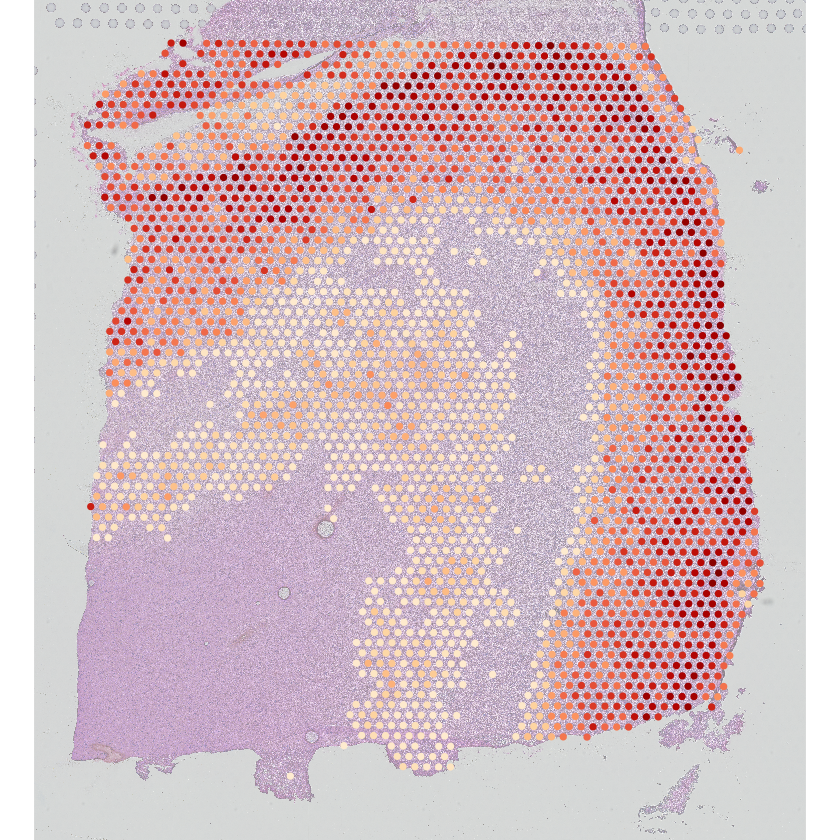

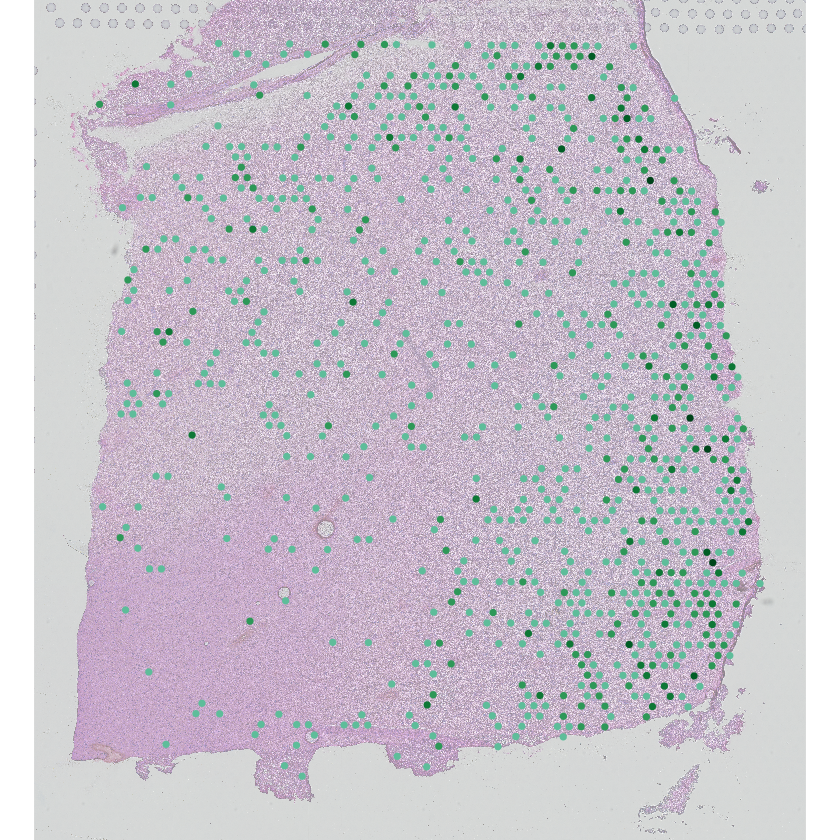

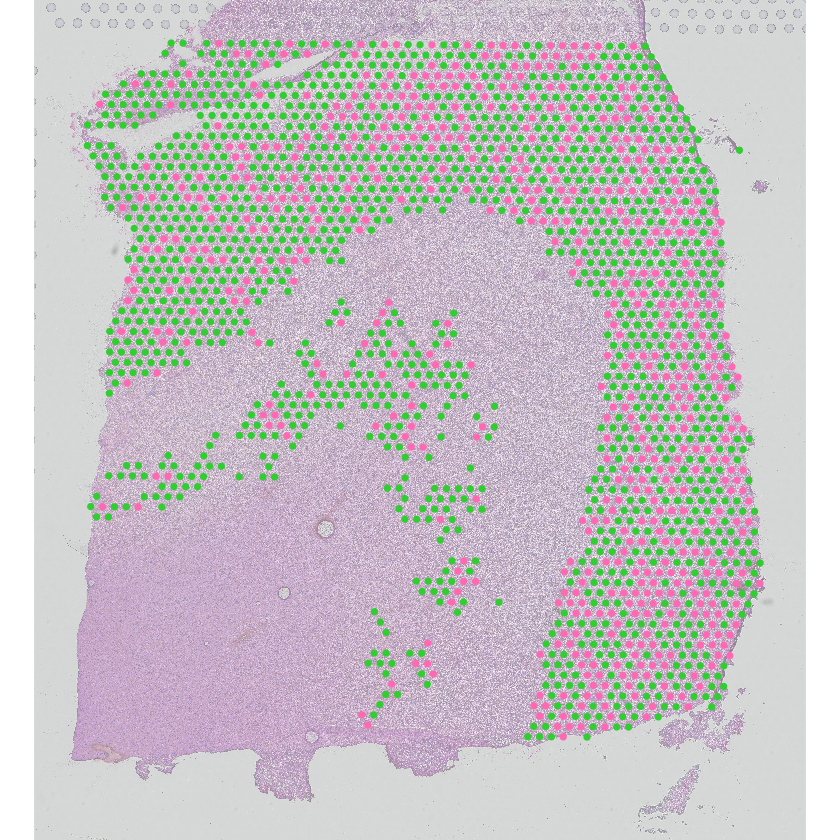

In [74]:
for (i in 1:3) {
    celltype <- demo_celltypes[i]
    gene <- markers[i]

    # Proportion of cell type
    p1 <- mcubePlotPropCellType(
        mcube_object@proportion, mcube_object@coordinates, celltype,
        he_image = he_image_0.5[ylim[1]:ylim[2], xlim[1]:xlim[2], ], background = FALSE,
        xlim = xlim, ylim = ylim
    ) +
        scale_x_continuous(limits = xlim, expand = c(0, 0)) +
        scale_y_continuous(trans = "reverse", limits = rev(ylim), expand = c(0, 0)) +
        theme_void() +
        theme(
            plot.title = element_blank(),
            axis.title = element_blank(),
            axis.text = element_blank(),
            axis.ticks = element_blank(),
            panel.grid = element_blank(),
            legend.position = "none"
        )
    ggsave(
        filename = file.path(
            RESULT_PATH,
            paste0("proportion_", celltype, "_slice", slice_idx, ".png")
        ),
        plot = p1, width = 4, height = 4, bg = "transparent"
    )

    # Gene expression
    p2 <- mcubePlotExpr(
        mcube_object@counts, mcube_object@coordinates, gene,
        he_image = he_image_0.5[ylim[1]:ylim[2], xlim[1]:xlim[2], ], background = FALSE,
        xlim = xlim, ylim = ylim, palettes = pals::brewer.bugn(20)[11:20]
    ) +
    scale_x_continuous(limits = xlim, expand = c(0, 0)) +
    scale_y_continuous(trans = "reverse", limits = rev(ylim), expand = c(0, 0)) +
    theme_void() +
    theme(
        plot.title = element_blank(),
        axis.title = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        panel.grid = element_blank(),
        legend.position = "none"
    )
    ggsave(
        filename = file.path(
            RESULT_PATH,
            paste0(gene, "_slice", slice_idx, ".png")
        ),
        plot = p2, width = 4, height = 4, bg = "transparent"
    )

    # Cell-type-specific gene expression variations
    p3 <- mcubePlotExprCellTypeBinary(
        mcube_object,
        celltype = celltype, gene = gene,
        he_image = he_image_0.5[ylim[1]:ylim[2], xlim[1]:xlim[2], ], background = FALSE,
        xlim = xlim, ylim = ylim
    ) +
    scale_x_continuous(limits = xlim, expand = c(0, 0)) +
    scale_y_continuous(trans = "reverse", limits = rev(ylim), expand = c(0, 0)) +
    theme_void() +
    theme(
        plot.title = element_blank(),
        axis.title = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        panel.grid = element_blank(),
        legend.position = "none"
    )
    ggsave(
        filename = file.path(
            RESULT_PATH,
            paste0(celltype, "_", gene, "_slice", slice_idx, ".png")
        ),
        plot = p3, width = 4, height = 4, bg = "transparent"
    )
}

p1
p2
p3

The spatial expression patterns of these marker genes are mainly affected by the distribution of cell type proportions across space.
`MCube` results reveal that their spatial variations are evenly distributed within a specific cell type by accounting for the cell type composition, and thus not cell-type-specific SVGs.